# Accelerate Modeling at Scale with SAS Viya

Instead of building models sequentially and tuning each one to perfection, the following code allows a data scientist to build hundreds of models simultaneously, testing different algorithms for each micro segment leveraging SAS Viya’s in-memory, multi-threaded, distributed compute environment. 

The code automatically generates and assesses all models per micro segment, selects micro segment champion model and top challenger models, and then publishes all models into a model repository per customer segment for governance, monitoring, and publishing.

### SAS Viya environment parameters

In [2]:
import getpass

# Specify your SAS Viya Linux server where SASLogon service is located
viyahost = #YOUR SERVER

# Specify your SAS Viya username and password
username = #YOUR USERNAME
print('Provide Password:')
password=getpass.getpass()

Provide Password:
········


In [1]:
import swat
from swat.cas.connection import getnext
import pandas as pd
import numpy as np
from IPython.display import display
import params_box
import importlib
from params_box import impute_params, partition_params, get_model_segments, set_model_params, train_non_swat_model, score_non_swat_model, publish_automl, load_assess_files
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Initiate session and load actionsets

In [3]:
s = swat.CAS(viyahost, 5570, username=username, password=password)

In [4]:
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'neuralNet', 'regression', 'astore']
for a in actionsets:
    s.loadactionset(a)

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'astore'.


## Define Data, Models, and Parameters

In [6]:
# rejected_vars: 
# customer_state, customer_gender, issue_level2, mfg_samsung, handset_age_grp, state_lat, state_long, Customer_ID_1, forecast_region, customer_address, customer_name, verbatims, resolution, issue_level1, customer_city, customer_primary_phone
tab = params_box.tab()
display(tab)

Use the head method to display first few rows of table

In [7]:
# get caslib and table from input
caslib = params_box.caslib(tab)
table = params_box.table(tab)

# create reference to telco_detractor_table in memory
tbl = s.CASTable(name=table, caslib=caslib)
tbl.head(5)

Selected Rows from Table LOOKING_GLASS_V4

   Customer_ID  upsell_xsell  churn  lifetime_value  avg_arpu_3m   acct_age  \
0        471.0           0.0    0.0          1693.8    44.980000  55.000000   
1       1057.0           0.0    0.0         38682.5    44.989330  47.000000   
2       1177.0           0.0    0.0          5526.4    51.775434  46.176471   
3       1181.0           0.0    0.0           505.6    51.775434  75.000000   
4       1185.0           1.0    0.0          9143.2    83.320000  50.000000   

   billing_cycle  nbr_contracts_ltd credit_class sales_channel  ...  \
0            4.0                7.0        prime      Indirect  ...   
1            3.0                5.0        prime      Indirect  ...   
2            7.0                4.8        prime        Retail  ...   
3            7.0                4.8        prime        Retail  ...   
4            5.0                3.0        prime      Indirect  ...   

   pymts_late_ltd  calls_care_ltd MB_Data_Usg_M04 MB_Data_Usg_M05  \
0             5.0            57.0             0.0             0.0   
1             5.0           115.0             0.0             0.0   
2             5.0            78.0             0.0             0.0   
3             5.0            76.0             0.0             0.0   
4             5.0            80.0             0.0             0.0   

  MB_Data_Usg_M06  MB_Data_Usg_M07  MB_Data_Usg_M08  MB_Data_Usg_M09  \
0             0.0              0.0              0.0              0.0   
1             0.0              0.0            330.0            646.0   
2             0.0              0.0              0.0              0.0   
3             0.0              0.0              0.0              0.0   
4             0.0              0.0              0.0              0.0   

   seconds_of_data_norm  seconds_of_data_log  
0                  60.0             4.110874  
1               48300.0            10.785208  
2               14700.0             9.595671  
3                   0.0             0.000000  
4               15840.0             9.670357  

[5 rows x 128 columns]

Print summary statistics using cardinality action set

In [8]:
# cardinality action set
tbl.cardinality.summarize(cardinality = dict(name = 'data_card', replace = True))
df_data_card = s.CASTable('data_card').to_frame() # bring the data locally

# get list of nominal and numerical variables
type_c = list(df_data_card.query('_TYPE_ == "C"')['_VARNAME_'])
type_n = list(df_data_card.query('_TYPE_ == "N"')['_VARNAME_'])

# print summary statistics
df_data_card['_PCTMISS_'] = (df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100
print('\n', 'Summary Statistics'.center(90, ' '))
df_data_card[['_VARNAME_','_TYPE_','_PCTMISS_','_MIN_','_MAX_','_MEAN_','_STDDEV_','_SKEWNESS_','_KURTOSIS_']].round(2)

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 1.419453 seconds.

                                     Summary Statistics                                    


_VARNAME_ _TYPE_  _PCTMISS_     _MIN_       _MAX_  \
0              Customer_ID      N       0.00    471.00  3999922.00   
1             upsell_xsell      N       0.00      0.00        1.00   
2                    churn      N       0.00      0.00        1.00   
3           lifetime_value      N       0.00 -14006.00    60740.20   
4              avg_arpu_3m      N       1.98      0.00      160.38   
5                 acct_age      N       0.00     18.00      165.00   
6            billing_cycle      N       0.00      1.00       12.00   
7        nbr_contracts_ltd      N       0.00      1.00       16.65   
8             credit_class      C       0.00       NaN         NaN   
9            sales_channel      C       0.00       NaN         NaN   
10               rfm_score      N       0.00    111.00      333.00   
11           Est_HH_Income      N       0.00      0.00   263400.00   
12                  region      C       0.00       NaN         NaN   
13                   state      C       0.00       NaN         NaN   
14                    city      C       0.00       NaN         NaN   
15         zipcode_primary      N       0.00   1001.00    99925.00   
16              region_lat      N       0.00     32.62       43.90   
17             region_long      N       0.00   -120.98      -71.48   
18               state_lat      N       0.00     20.71       61.29   
19              state_long      N       0.00   -156.87      -69.42   
20                city_lat      N       5.59     19.43       71.29   
21               city_long      N       5.59   -170.48      -67.08   
22                 zip_lat      N       0.00     19.10       71.30   
23                zip_long      N       0.00   -170.41      -67.09   
24       cs_med_home_value      N       0.22      0.00        9.99   
25       cs_pct_home_owner      N       0.22      0.00        0.99   
26              cs_ttl_pop      N       2.33      7.00   114124.00   
27             cs_hispanic      N       2.45      0.04       98.91   
28            cs_caucasian      N       2.34      0.39       99.87   
29             cs_afr_amer      N       3.29      0.01      100.00   
..                     ...    ...        ...       ...         ...   
98      days_openwrkorders      N       0.00      0.00      377.00   
99       resolved_complnts      N       0.00      0.00       12.00   
100        calls_care_acct      N       0.00      0.00        9.00   
101  calls_care_3mavg_acct      N       0.00      0.00        7.06   
102  calls_care_6mavg_acct      N       0.00      0.00        3.19   
103   res_calls_3mavg_acct      N       0.00      0.00        5.08   
104   res_calls_6mavg_acct      N       0.00      0.00        2.48   
105     last_rep_sat_score      N       0.00     -1.00       10.00   
106            call_center      C       0.00       NaN         NaN   
107           issue_level1      C       0.00       NaN         NaN   
108           issue_level2      C       0.00       NaN         NaN   
109        call_category_1      C       0.00       NaN         NaN   
110        call_category_2      C       0.00       NaN         NaN   
111             resolution      C       0.00       NaN         NaN   
112        network_mention      N       0.00      0.00        1.00   
113        service_mention      N       0.00      0.00        1.00   
114          price_mention      N       0.00      0.00        2.00   
115              verbatims      C       0.00       NaN         NaN   
116             times_susp      N       0.00      0.00        6.00   
117         curr_days_susp      N       0.00      0.00       43.00   
118         pymts_late_ltd      N       0.00      0.00       10.00   
119         calls_care_ltd      N       0.00      0.00      266.00   
120        MB_Data_Usg_M04      N       0.00      0.00    14606.00   
121        MB_Data_Usg_M05      N       0.00      0.00    24707.00   
122        MB_Data_Usg_M06      N       0.00      0.00    29676.00   
123        MB_Data_Usg_M07 

Plot distributions of variables

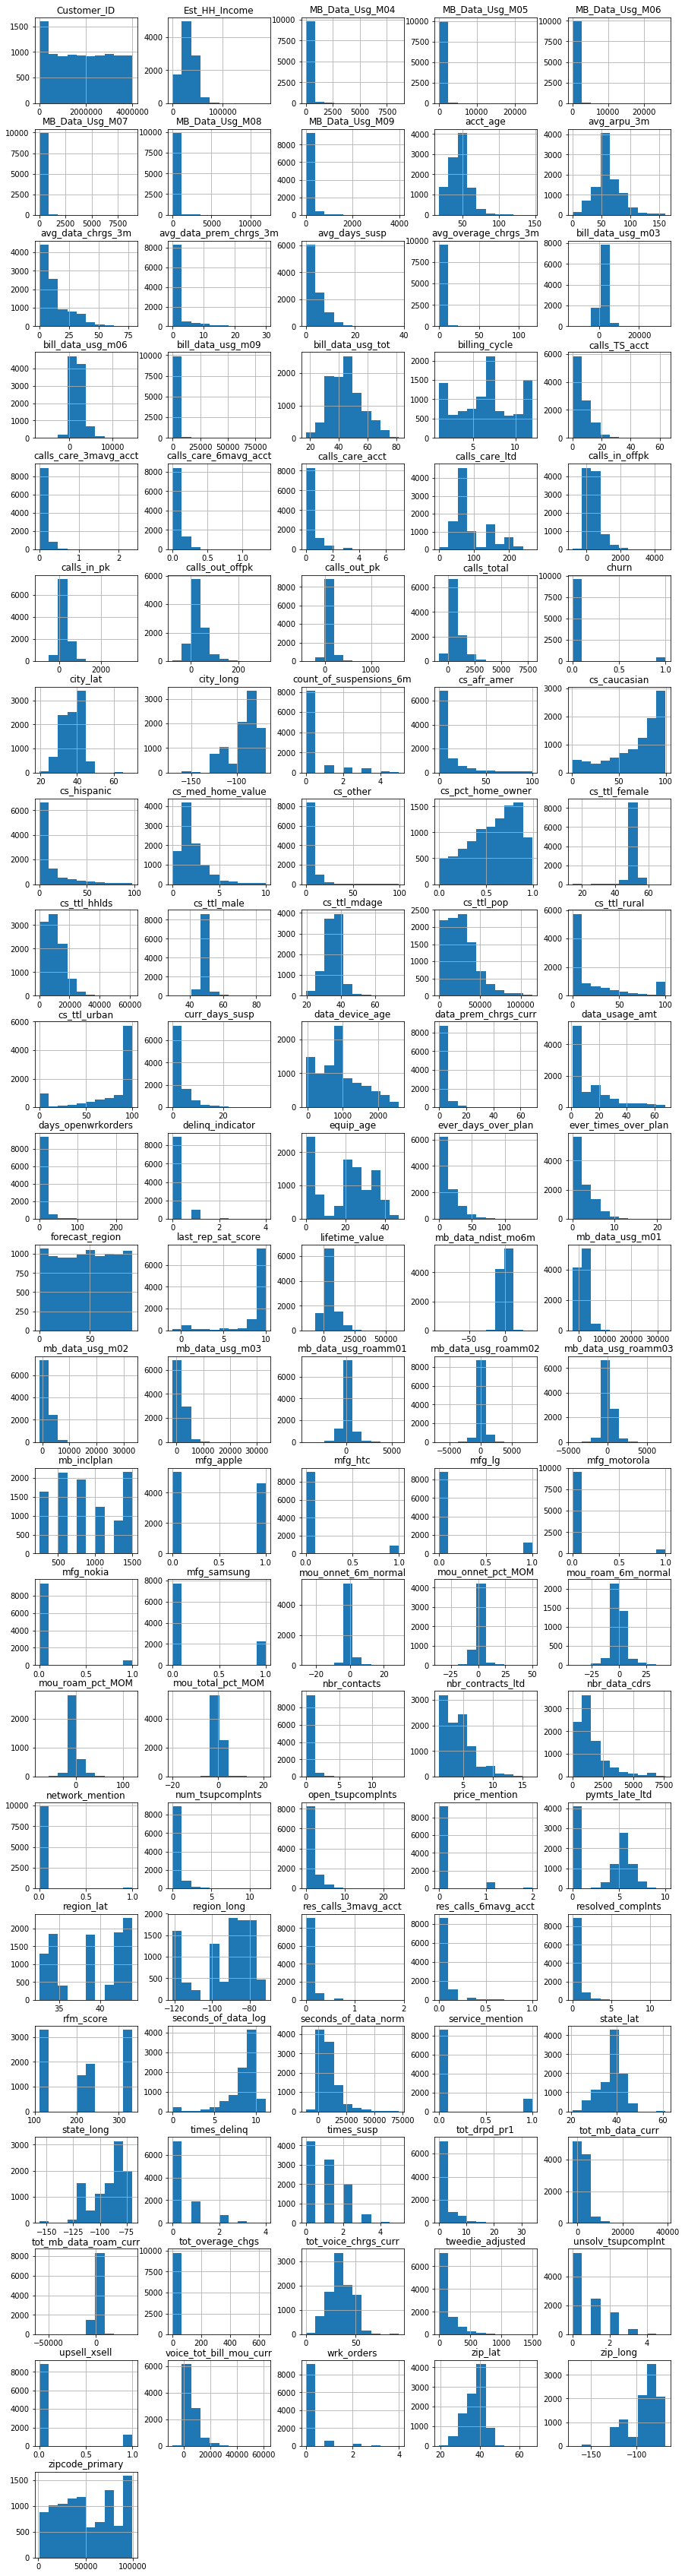

In [9]:
# Use the built in hist() method to plot the distribution of every variable
tbl.hist(figsize = (15,75), layout = (28, 5));

### Define up to 2 segment variables, and specify variables to reject

In [9]:
# obtain inputs from box
params_map = params_box.get(tab)

# extract target, segment1, segment2, and rejected values
target = params_map['setup']['target']
segment1 = params_map['setup']['seg1']
segment2 = params_map['setup']['seg2']
rejected = params_map['setup']['rejected']

# display rejected variables
pd.DataFrame(rejected, columns = ['Rejected Variables'])

Rejected Variables
0           customer_state
1          customer_gender
2             issue_level2
3              mfg_samsung
4          handset_age_grp
5                state_lat
6               state_long
7            Customer_ID_1
8          forecast_region
9         customer_address
10           customer_name
11               verbatims
12              resolution
13            issue_level1
14           customer_city
15  customer_primary_phone

Display unique values of target, segment 1, and segment 2

In [10]:
# display distinct values of Target variable
target_distinct = tbl[target].unique()

# display distinct values of Segment 1 variable
segment1_distinct = tbl[segment1].unique()

# display distinct value of Segment 2 variable
segment2_distinct = tbl[segment2].unique()

df1 = pd.DataFrame(target_distinct, columns = ['Unique target Values'])
df2 = pd.DataFrame(segment1_distinct, columns = ['Unique ' + segment1])
df3 = pd.DataFrame(segment2_distinct, columns = ['Unique ' + segment2])

display(df1, df2, df3)

Unique target Values
0                   0.0
1                   1.0

Unique region
0    Great Lakes
1  Greater Texas
2   Mid Atlantic
3        Midwest
4       Mtn West
5    New England
6        Pacific
7          South
8      Southwest

Unique handset
0          Apple
1            HTC
2             LG
3       Motorola
4          Nokia
5        Samsung
6        Unknown

Remove rejected variables from input variables, and show which variables remain

In [11]:
# get a list of all inputs
varnames = list(df_data_card['_VARNAME_'])
varnames.remove(target)

# create list of non-rejected variables
inputs = [item for item in varnames if item not in rejected]

# get nominal and numerical variables in inputs
inputs_c = [item for item in inputs if item in type_c]
inputs_n = [item for item in inputs if item in type_n]

# display input variables and their type
inputs_df = pd.DataFrame(inputs, columns=['Variables'])
inputs_df['Type'] = inputs_df['Variables'].apply(lambda x: 'C' if x in inputs_c else 'N')
display(inputs_df)

Variables Type
0              Customer_ID    N
1                    churn    N
2           lifetime_value    N
3              avg_arpu_3m    N
4                 acct_age    N
5            billing_cycle    N
6        nbr_contracts_ltd    N
7             credit_class    C
8            sales_channel    C
9                rfm_score    N
10           Est_HH_Income    N
11                  region    C
12                   state    C
13                    city    C
14         zipcode_primary    N
15              region_lat    N
16             region_long    N
17                city_lat    N
18               city_long    N
19                 zip_lat    N
20                zip_long    N
21       cs_med_home_value    N
22       cs_pct_home_owner    N
23              cs_ttl_pop    N
24             cs_hispanic    N
25            cs_caucasian    N
26             cs_afr_amer    N
27                cs_other    N
28            cs_ttl_urban    N
29            cs_ttl_rural    N
..                     ...  ...
88       open_tsupcomplnts    N
89        num_tsupcomplnts    N
90      unsolv_tsupcomplnt    N
91              wrk_orders    N
92      days_openwrkorders    N
93       resolved_complnts    N
94         calls_care_acct    N
95   calls_care_3mavg_acct    N
96   calls_care_6mavg_acct    N
97    res_calls_3mavg_acct    N
98    res_calls_6mavg_acct    N
99      last_rep_sat_score    N
100            call_center    C
101        call_category_1    C
102        call_category_2    C
103        network_mention    N
104        service_mention    N
105          price_mention    N
106             times_susp    N
107         curr_days_susp    N
108         pymts_late_ltd    N
109         calls_care_ltd    N
110        MB_Data_Usg_M04    N
111        MB_Data_Usg_M05    N
112        MB_Data_Usg_M06    N
113        MB_Data_Usg_M07    N
114        MB_Data_Usg_M08    N
115        MB_Data_Usg_M09    N
116   seconds_of_data_norm    N
117    seconds_of_data_log    N

[118 rows x 2 columns]

## Generate Segments Based on Chosen Variables

In [12]:
# create segments
class1 = tbl[segment1].unique().tolist()
class2 = tbl[segment2].unique().tolist()

# creates the main segments according to the two inputs
if not segment2:
    segments_main = [{segment1: i} for i in class1]
else:
    segments_main = [{segment1: i, segment2: j} for i in class1 for j in class2]

# create an id for each segment
for idx,val in enumerate(segments_main):
    val['segment_id'] = idx

# display the segments
segments_pd = pd.DataFrame(segments_main, columns=['segment_id', segment1, segment2])
segments_pd.set_index('segment_id')

region   handset
segment_id                         
0             Great Lakes     Apple
1             Great Lakes       HTC
2             Great Lakes        LG
3             Great Lakes  Motorola
4             Great Lakes     Nokia
5             Great Lakes   Samsung
6             Great Lakes   Unknown
7           Greater Texas     Apple
8           Greater Texas       HTC
9           Greater Texas        LG
10          Greater Texas  Motorola
11          Greater Texas     Nokia
12          Greater Texas   Samsung
13          Greater Texas   Unknown
14           Mid Atlantic     Apple
15           Mid Atlantic       HTC
16           Mid Atlantic        LG
17           Mid Atlantic  Motorola
18           Mid Atlantic     Nokia
19           Mid Atlantic   Samsung
20           Mid Atlantic   Unknown
21                Midwest     Apple
22                Midwest       HTC
23                Midwest        LG
24                Midwest  Motorola
25                Midwest     Nokia
26                Midwest   Samsung
27                Midwest   Unknown
28               Mtn West     Apple
29               Mtn West       HTC
...                   ...       ...
33               Mtn West   Samsung
34               Mtn West   Unknown
35            New England     Apple
36            New England       HTC
37            New England        LG
38            New England  Motorola
39            New England     Nokia
40            New England   Samsung
41            New England   Unknown
42                Pacific     Apple
43                Pacific       HTC
44                Pacific        LG
45                Pacific  Motorola
46                Pacific     Nokia
47                Pacific   Samsung
48                Pacific   Unknown
49                  South     Apple
50                  South       HTC
51                  South        LG
52                  South  Motorola
53                  South     Nokia
54                  South   Samsung
55                  South   Unknown
56              Southwest     Apple
57              Southwest       HTC
58              Southwest        LG
59              Southwest  Motorola
60              Southwest     Nokia
61              Southwest   Samsung
62              Southwest   Unknown

[63 rows x 2 columns]

Define function to:  

1) create a new session for each segment  
2) subset the main table to get the segment table  

In [15]:
def create_session(conn, segment, table, segment_var1, segment_var2=None, caslib='Public'):
    # create a new session
    new_sess = conn.copy()
    segment['session'] = new_sess
    
    # load actionsets for new session
    actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'neuralNet', 'regression', 'astore']
    for a in actionsets:
        new_sess.loadactionset(actionset=a)
    
    # subset main table according to segments, using a where clause
    tbl = new_sess.CASTable(name=table, caslib=caslib)
    query1 = "{seg1} = {seg1_value}" 
    query2 = "{seg2} = {seg2_value}"
    query1_str = query1.format(seg1 = segment_var1, seg1_value = '"{}"'.format(segment[segment_var1]) 
                 if isinstance(segment[segment_var1], str) else segment[segment_var1])
    query2_str = query2.format(seg2 = segment_var2, seg2_value = '"{}"'.format(segment[segment_var2]) 
                 if isinstance(segment[segment_var2], str) else segment[segment_var2])
    if segment_var2:
        segment_tbl = tbl.query(query1_str + ' and ' + query2_str)
    else:
        segment_tbl = tbl.query(query1_str)
    
    # impute segment
    new_sess.invoke('impute', **impute_params(segment_tbl, out=table+'_im'))
    
    # partition segment
    new_sess.invoke('srs', **partition_params(table+'_im', out=table+'_im', replace=True))
    
    # map the table to the segment
    segment['segment_tbl'] = new_sess.CASTable(table+'_im')
    segment['non_partind'] = segment_tbl
    
    return segment

### Create Segments, Calculate Number of Observations and Target Event Rate for Each Segment

In [16]:
# create one session per segment
for segment in segments_main:
    create_session(s, segment, table, segment1, segment2)

# calculate target event rate for each segment
for segment in segments_main:
    # getting count of non-missing values for each segment
    segment['count'] = segment['segment_tbl'].count()[target]
    # getting count of event for each segment
    segment['event_count'] = segment['segment_tbl'].query("%s = %s" % (target, 1)).count()[target]
    # calculating target event rate percentage for each segment
    if segment['count'] == 0:
        segment['tgt_event_rate'] = 0
    else:
        segment['tgt_event_rate'] = segment['event_count'] / segment['count']

# terminate sessions
for segment in segments_main:
    segment['session'].close()
    segment['session'] = None

# display the segments
segments_pd = pd.DataFrame(segments_main, columns=['segment_id', segment1, segment2, 'count', 'tgt_event_rate'])
segments_pd.set_index('segment_id')

region   handset  count  tgt_event_rate
segment_id                                                
0             Great Lakes     Apple   6171        0.117809
1             Great Lakes       HTC    780        0.123077
2             Great Lakes        LG    984        0.141260
3             Great Lakes  Motorola    354        0.124294
4             Great Lakes     Nokia    495        0.135354
5             Great Lakes   Samsung   2067        0.107402
6             Great Lakes   Unknown     49        0.183673
7           Greater Texas     Apple   4073        0.133071
8           Greater Texas       HTC    515        0.132039
9           Greater Texas        LG    671        0.114754
10          Greater Texas  Motorola    244        0.127049
11          Greater Texas     Nokia    359        0.128134
12          Greater Texas   Samsung   1350        0.129630
13          Greater Texas   Unknown     24        0.041667
14           Mid Atlantic     Apple   5846        0.111016
15           Mid Atlantic       HTC    713        0.120617
16           Mid Atlantic        LG    928        0.127155
17           Mid Atlantic  Motorola    356        0.103933
18           Mid Atlantic     Nokia    518        0.138996
19           Mid Atlantic   Samsung   1965        0.132824
20           Mid Atlantic   Unknown     31        0.161290
21                Midwest     Apple   1249        0.118495
22                Midwest       HTC    142        0.161972
23                Midwest        LG    210        0.138095
24                Midwest  Motorola     92        0.097826
25                Midwest     Nokia    129        0.100775
26                Midwest   Samsung    456        0.103070
27                Midwest   Unknown      6        0.166667
28               Mtn West     Apple    668        0.125749
29               Mtn West       HTC    106        0.113208
...                   ...       ...    ...             ...
33               Mtn West   Samsung    264        0.121212
34               Mtn West   Unknown      6        0.000000
35            New England     Apple   1506        0.125498
36            New England       HTC    215        0.125581
37            New England        LG    250        0.128000
38            New England  Motorola     87        0.126437
39            New England     Nokia    120        0.150000
40            New England   Samsung    457        0.142232
41            New England   Unknown     13        0.076923
42                Pacific     Apple   5133        0.118254
43                Pacific       HTC    665        0.114286
44                Pacific        LG    889        0.127109
45                Pacific  Motorola    320        0.118750
46                Pacific     Nokia    429        0.088578
47                Pacific   Samsung   1691        0.132466
48                Pacific   Unknown     30        0.300000
49                  South     Apple   5898        0.122075
50                  South       HTC    721        0.124827
51                  South        LG   1024        0.125977
52                  South  Motorola    355        0.107042
53                  South     Nokia    475        0.122105
54                  South   Samsung   2073        0.115292
55                  South   Unknown     35        0.142857
56              Southwest     Apple   1211        0.116433
57              Southwest       HTC    153        0.078431
58              Southwest        LG    224        0.120536
59              Southwest  Motorola     86        0.127907
60              Southwest     Nokia    100        0.120000
61              Southwest   Samsung    409        0.095355
62              Southwest   Unknown      3        0.000000

[63 rows x 4 columns]

Set to reject segments not meeting target event rate range, or minimum number of observations

In [17]:
# get parameters from input box
min_obs = params_box.get(tab)['setup']['min_obs']
event_rate = params_box.get(tab)['setup']['tgt_event_rate']

# set to use or reject segment
for segment in segments_main:
    if segment['count'] < min_obs:
        segment['use'] = False
    elif segment['tgt_event_rate'] < event_rate[0] or segment['tgt_event_rate'] > event_rate[1]:
        segment['use'] = False
    else:
        segment['use'] = True

# display information about individual segments including count and target event rates
segments_r_pd = pd.DataFrame(segments_main, columns=['segment_id', segment1, segment2, 'count', 'tgt_event_rate', 'use'])
segments_r_pd.set_index('segment_id')

# display number of segments to be included and excluded
use_count = segments_r_pd.loc[segments_r_pd['use'] == True].count()['use']
exclude_count = segments_r_pd.loc[segments_r_pd['use'] == False].count()['use']
print ("Count of segments to be included : " , use_count)
print("Count of segments to be excluded : ", exclude_count)
display(segments_r_pd)

Count of segments to be included :  40
Count of segments to be excluded :  23


segment_id         region   handset  count  tgt_event_rate    use
0            0    Great Lakes     Apple   6171        0.117809   True
1            1    Great Lakes       HTC    780        0.123077   True
2            2    Great Lakes        LG    984        0.141260   True
3            3    Great Lakes  Motorola    354        0.124294   True
4            4    Great Lakes     Nokia    495        0.135354   True
5            5    Great Lakes   Samsung   2067        0.107402   True
6            6    Great Lakes   Unknown     49        0.183673  False
7            7  Greater Texas     Apple   4073        0.133071   True
8            8  Greater Texas       HTC    515        0.132039   True
9            9  Greater Texas        LG    671        0.114754   True
10          10  Greater Texas  Motorola    244        0.127049   True
11          11  Greater Texas     Nokia    359        0.128134   True
12          12  Greater Texas   Samsung   1350        0.129630   True
13          13  Greater Texas   Unknown     24        0.041667  False
14          14   Mid Atlantic     Apple   5846        0.111016   True
15          15   Mid Atlantic       HTC    713        0.120617   True
16          16   Mid Atlantic        LG    928        0.127155   True
17          17   Mid Atlantic  Motorola    356        0.103933   True
18          18   Mid Atlantic     Nokia    518        0.138996   True
19          19   Mid Atlantic   Samsung   1965        0.132824   True
20          20   Mid Atlantic   Unknown     31        0.161290  False
21          21        Midwest     Apple   1249        0.118495   True
22          22        Midwest       HTC    142        0.161972  False
23          23        Midwest        LG    210        0.138095   True
24          24        Midwest  Motorola     92        0.097826  False
25          25        Midwest     Nokia    129        0.100775  False
26          26        Midwest   Samsung    456        0.103070   True
27          27        Midwest   Unknown      6        0.166667  False
28          28       Mtn West     Apple    668        0.125749   True
29          29       Mtn West       HTC    106        0.113208  False
..         ...            ...       ...    ...             ...    ...
33          33       Mtn West   Samsung    264        0.121212   True
34          34       Mtn West   Unknown      6        0.000000  False
35          35    New England     Apple   1506        0.125498   True
36          36    New England       HTC    215        0.125581   True
37          37    New England        LG    250        0.128000   True
38          38    New England  Motorola     87        0.126437  False
39          39    New England     Nokia    120        0.150000  False
40          40    New England   Samsung    457        0.142232   True
41          41    New England   Unknown     13        0.076923  False
42          42        Pacific     Apple   5133        0.118254   True
43          43        Pacific       HTC    665        0.114286   True
44          44        Pacific        LG    889        0.127109   True
45          45        Pacific  Motorola    320        0.118750   True
46          46        Pacific     Nokia    429        0.088578  False
47          47        Pacific   Samsung   1691        0.132466   True
48          48        Pacific   Unknown     30        0.300000  False
49          49          South     Apple   5898        0.122075   True
50          50          South       HTC    721        0.124827   True
51          51          South        LG   1024        0.125977   True
52          52          South  Motorola    355        0.107042   True
53          53          South     Nokia    475        0.122105   True
54          54          South   Samsung   2073        0.115292   True
55          55          South   Unknown     35        0.142857  False
56          56      Southwest     Apple   1211        0.116433   True
57          57      Southwest       HTC    153        0.078431  False
58          58

In [18]:
segments_r_pd[segments_r_pd['use']==False]

segment_id         region   handset  count  tgt_event_rate    use
6            6    Great Lakes   Unknown     49        0.183673  False
13          13  Greater Texas   Unknown     24        0.041667  False
20          20   Mid Atlantic   Unknown     31        0.161290  False
22          22        Midwest       HTC    142        0.161972  False
24          24        Midwest  Motorola     92        0.097826  False
25          25        Midwest     Nokia    129        0.100775  False
27          27        Midwest   Unknown      6        0.166667  False
29          29       Mtn West       HTC    106        0.113208  False
30          30       Mtn West        LG     81        0.172840  False
31          31       Mtn West  Motorola     27        0.111111  False
32          32       Mtn West     Nokia     56        0.107143  False
34          34       Mtn West   Unknown      6        0.000000  False
38          38    New England  Motorola     87        0.126437  False
39          39    New England     Nokia    120        0.150000  False
41          41    New England   Unknown     13        0.076923  False
46          46        Pacific     Nokia    429        0.088578  False
48          48        Pacific   Unknown     30        0.300000  False
55          55          South   Unknown     35        0.142857  False
57          57      Southwest       HTC    153        0.078431  False
59          59      Southwest  Motorola     86        0.127907  False
60          60      Southwest     Nokia    100        0.120000  False
61          61      Southwest   Samsung    409        0.095355  False
62          62      Southwest   Unknown      3        0.000000  False

## Train Models in Parallel - Generate One Session Per Model

### Functions to Train, Score, and Assess

In [129]:
viyaurl = '19w47mpp-1.gtp-americas.sashq-d.openstack.sas.com'
# viyaurl = 'pdcesx15026.exnet.sas.com'

def train_segment(segment, tab, username, password, viyaurl):
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        sess = segment['session']
        if segment['train_params']:
            sess.invoke(**segment['train_params'])
        return sess
    return train_non_swat_model(segment, tab, username, password, viyaurl)
        

def score_segment(segment, tab, username):
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        sess = segment['session']
        if segment['score_params']:
            sess.invoke(**segment['score_params'])
        return sess
    return score_non_swat_model(segment, tab, username)
    
def assess_segment(segment):
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        sess = segment['session']
        load_assess_files(segment)
        if segment['assess_params']:
            sess.invoke(**segment['assess_params'])
        return sess
    return None

Create one session per model per segment  
Set the training, scoring, and assess parameters

In [20]:
# generate all the model-segments
model_segments = get_model_segments(tab, segments_main)

# create the sessions using create_session
for segment in model_segments:
    create_session(s, segment, table, segment1, segment2)

# set the training, scoring, and assessment parameters
for segment in model_segments:
    set_model_params(tab, segment, inputs_c, inputs_n, tgt_type='C')
    
# display the result
segments_pd = pd.DataFrame(model_segments, columns=['segment_id', segment1, segment2, 'count', 'tgt_event_rate', 'model'])
segments_pd.set_index('segment_id')

region   handset  count  tgt_event_rate                model
segment_id                                                                   
0           Great Lakes     Apple   6171        0.117809        Decision Tree
0           Great Lakes     Apple   6171        0.117809    Gradient Boosting
0           Great Lakes     Apple   6171        0.117809        Random Forest
0           Great Lakes     Apple   6171        0.117809  Logistic Regression
0           Great Lakes     Apple   6171        0.117809       Neural Network
0           Great Lakes     Apple   6171        0.117809              XGBoost
0           Great Lakes     Apple   6171        0.117809           TensorFlow
1           Great Lakes       HTC    780        0.123077        Decision Tree
1           Great Lakes       HTC    780        0.123077    Gradient Boosting
1           Great Lakes       HTC    780        0.123077        Random Forest
1           Great Lakes       HTC    780        0.123077  Logistic Regression
1           Great Lakes       HTC    780        0.123077       Neural Network
1           Great Lakes       HTC    780        0.123077              XGBoost
1           Great Lakes       HTC    780        0.123077           TensorFlow
2           Great Lakes        LG    984        0.141260        Decision Tree
2           Great Lakes        LG    984        0.141260    Gradient Boosting
2           Great Lakes        LG    984        0.141260        Random Forest
2           Great Lakes        LG    984        0.141260  Logistic Regression
2           Great Lakes        LG    984        0.141260       Neural Network
2           Great Lakes        LG    984        0.141260              XGBoost
2           Great Lakes        LG    984        0.141260           TensorFlow
3           Great Lakes  Motorola    354        0.124294        Decision Tree
3           Great Lakes  Motorola    354        0.124294    Gradient Boosting
3           Great Lakes  Motorola    354        0.124294        Random Forest
3           Great Lakes  Motorola    354        0.124294  Logistic Regression
3           Great Lakes  Motorola    354        0.124294       Neural Network
3           Great Lakes  Motorola    354        0.124294              XGBoost
3           Great Lakes  Motorola    354        0.124294           TensorFlow
4           Great Lakes     Nokia    495        0.135354        Decision Tree
4           Great Lakes     Nokia    495        0.135354    Gradient Boosting
...                 ...       ...    ...             ...                  ...
52                South  Motorola    355        0.107042              XGBoost
52                South  Motorola    355        0.107042           TensorFlow
53                South     Nokia    475        0.122105        Decision Tree
53                South     Nokia    475        0.122105    Gradient Boosting
53                South     Nokia    475        0.122105        Random Forest
53                South     Nokia    475        0.122105  Logistic Regression
53                South     Nokia    475        0.122105       Neural Network
53                South     Nokia    475        0.122105              XGBoost
53                South     Nokia    475        0.122105           TensorFlow
54                South   Samsung   2073        0.115292        Decision Tree
54                South   Samsung   2073        0.115292    Gradient Boosting
54                South   Samsung   2073        0.115292        Random Forest
54                South   Samsung   2073        0.115292  Logistic Regression
54                South   Samsung   2073        0.115292       Neural Network
54                South   Samsung   2073        0.115292              XGBoost
54                South   Samsung   2073        0.115292           TensorFlow
56            Southwest     Apple   1211        0.116433        Decision Tree
56            Southwest     Apple   1211        0.116433    Gradient Boosting
56            Southwest     Apple   121

### Run Training on All Segments

In [21]:
# invoke training for all segments
for segment in model_segments:
    if segment['model'] not in ['XGBoost', 'TensorFlow']:
        print(segment['model'], segment['region'], segment['handset'])
        train_segment(segment, tab, username, password, viyaurl)

for segment in model_segments:
    if segment['model'] in ['XGBoost', 'TensorFlow']:
        print(segment['model'], segment['region'], segment['handset'])
        train_segment(segment, tab, username, password, viyaurl)



Decision Tree Great Lakes Apple
Gradient Boosting Great Lakes Apple
Random Forest Great Lakes Apple
Logistic Regression Great Lakes Apple
Neural Network Great Lakes Apple
Decision Tree Great Lakes HTC
Gradient Boosting Great Lakes HTC
Random Forest Great Lakes HTC
Logistic Regression Great Lakes HTC
Neural Network Great Lakes HTC
Decision Tree Great Lakes LG
Gradient Boosting Great Lakes LG
Random Forest Great Lakes LG
Logistic Regression Great Lakes LG
Neural Network Great Lakes LG
Decision Tree Great Lakes Motorola
Gradient Boosting Great Lakes Motorola
Random Forest Great Lakes Motorola
Logistic Regression Great Lakes Motorola
Neural Network Great Lakes Motorola
Decision Tree Great Lakes Nokia
Gradient Boosting Great Lakes Nokia
Random Forest Great Lakes Nokia
Logistic Regression Great Lakes Nokia
Neural Network Great Lakes Nokia
Decision Tree Great Lakes Samsung
Gradient Boosting Great Lakes Samsung
Random Forest Great Lakes Samsung
Logistic Regression Great Lakes Samsung
Neural Ne

TensorFlow Pacific Samsung
XGBoost South Apple
TensorFlow South Apple
XGBoost South HTC
TensorFlow South HTC
XGBoost South LG
TensorFlow South LG
XGBoost South Motorola
TensorFlow South Motorola
XGBoost South Nokia
TensorFlow South Nokia
XGBoost South Samsung
TensorFlow South Samsung
XGBoost Southwest Apple
TensorFlow Southwest Apple
XGBoost Southwest LG
TensorFlow Southwest LG


In [22]:
for segment in model_segments:
    if segment['model']=='AutoML':
        publish_automl(segment, tab, username, password, viyaurl)
        
# iterate through all sessions and get responses
train_sess = [segment['session'] for segment in model_segments if ((segment['train_params'] is not None) and segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow'])]
train_resp = [(sess, k, v) for resp,sess in getnext(*train_sess) for k,v in resp]

# extract and save training output
for segment in model_segments:
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        for sess,k,v in train_resp:
            if sess == segment['session']:
                segment['train_key']=k
                segment['train_value']=v

NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (FCONV=1E-7) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (FCONV=1E-7) satisfied.
NOTE: Convergence criterion (ABSGCONV=1E-7) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (FCONV=1E-7) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (FCONV=1E-7) satisfied.
NOTE: Convergence criterion (FCONV=1E-7) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (FCONV=1E-7) satisfied.
NOTE: Con

### Run Scoring on All Segments

In [134]:
for segment in model_segments:
    score_segment(segment, tab, username)

score_sess = [segment['session'] for segment in model_segments if ((segment['score_params'] is not None) and segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow'])]
score_resp = [(sess, k, v) for resp,sess in getnext(*score_sess) for k,v in resp]

for segment in model_segments:
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        for sess,k,v in score_resp:
            if sess == segment['session']:
                segment['score_key']=k
                segment['score_value']=v  

### Run Assessment on All Segments

In [147]:
for segment in model_segments:
    assess_segment(segment)

assess_sess = [segment['session'] for segment in model_segments if ((segment['assess_params'] is not None) and segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow'])]
assess_resp = [(sess, k, v) for resp,sess in getnext(*assess_sess) for k,v in resp]

for segment in model_segments:
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        for sess,k,v in assess_resp:
            if sess == segment['session']:
                if k == 'LIFTInfo':
                    segment['LIFTInfo']=v
                elif k == 'ROCInfo':
                    segment['ROCInfo']=v
                    v['misclass'] = 1-v['ACC']
                    segment['misclassification']=v[round(v['CutOff'], 2) == 0.5][['misclass']].iloc[0]['misclass']
                    segment['ks']=v[round(v['CutOff'], 2) == 0.5][['KS']]

### Draw Assessment Plots

#### ROC Curves

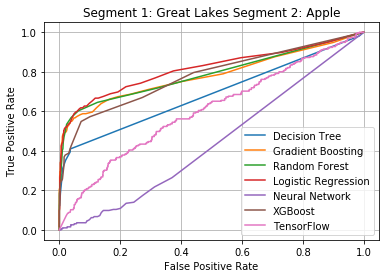

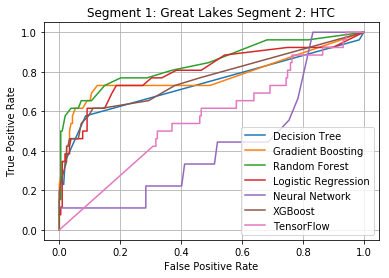

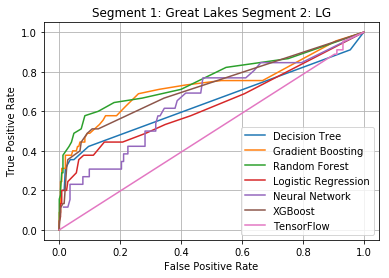

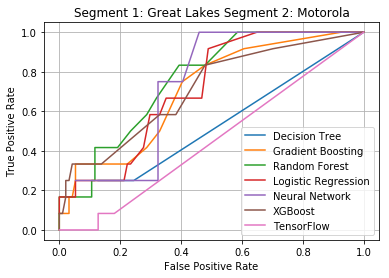

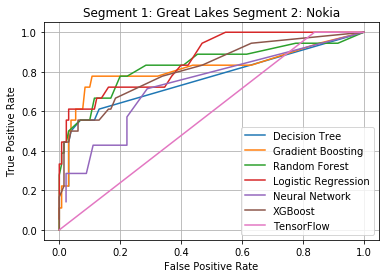

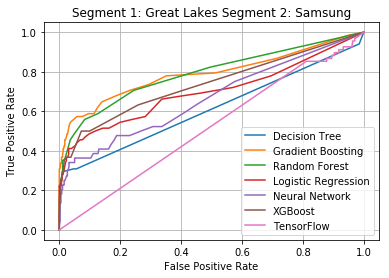

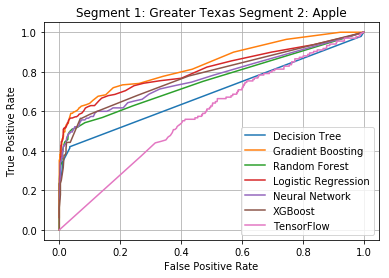

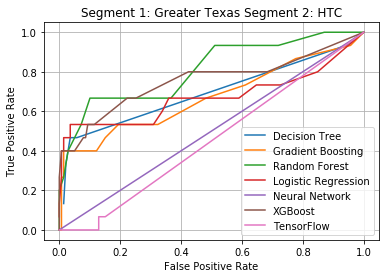

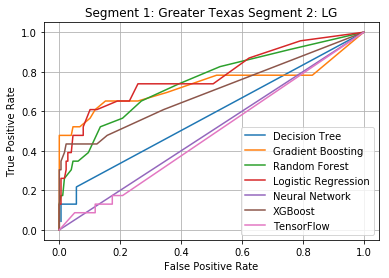

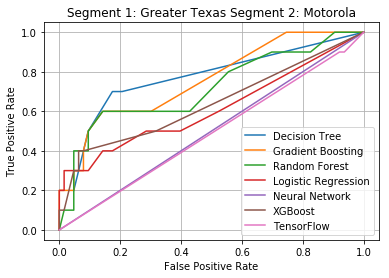

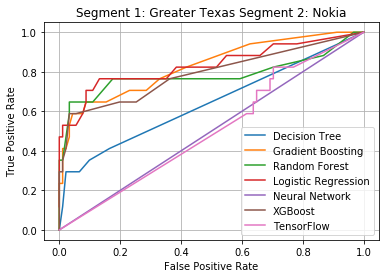

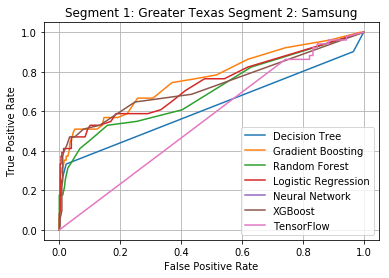

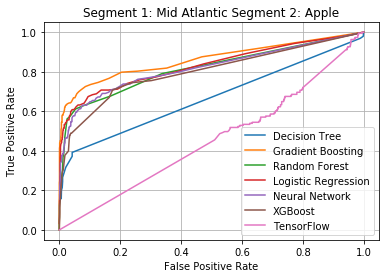

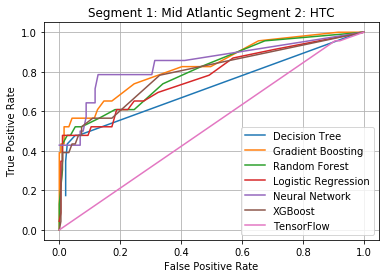

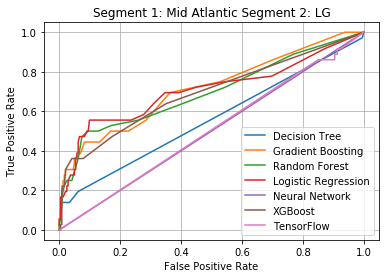

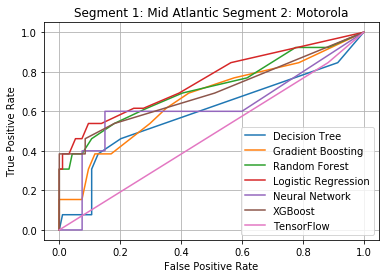

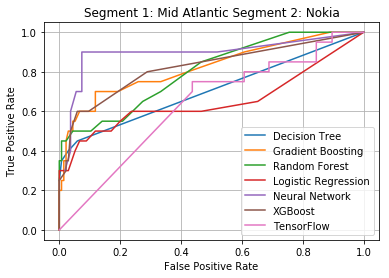

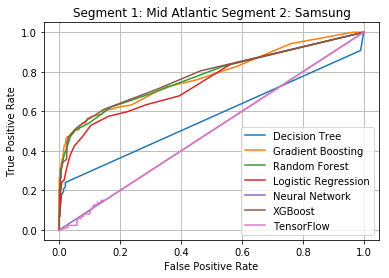

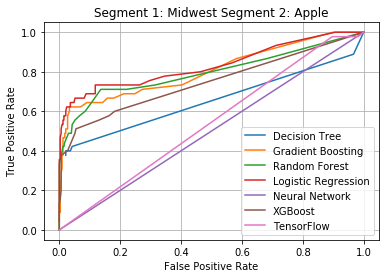

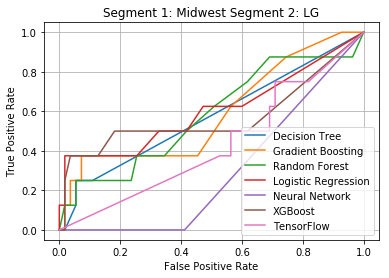

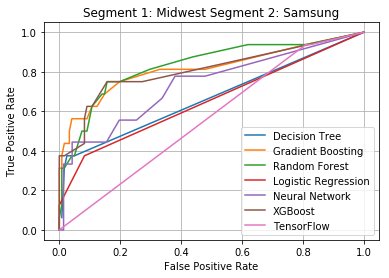

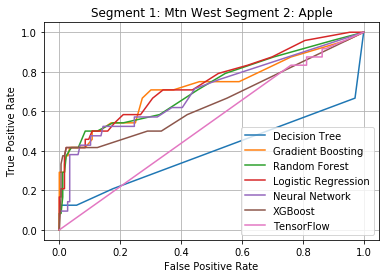

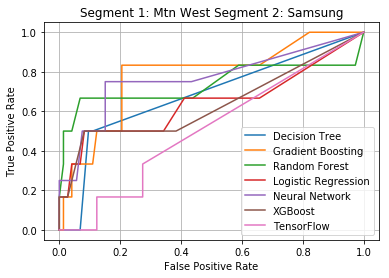

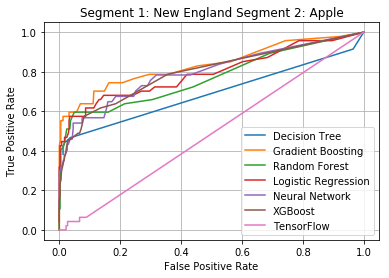

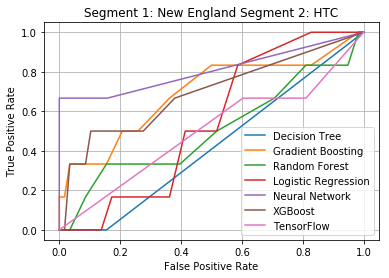

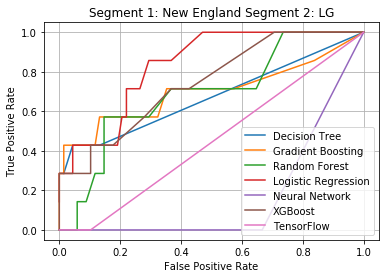

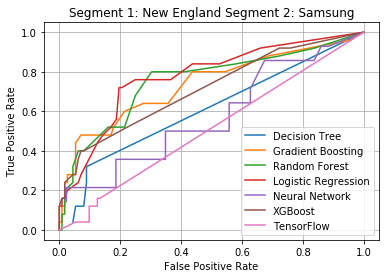

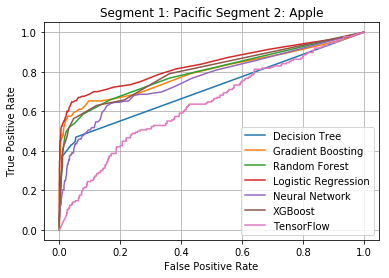

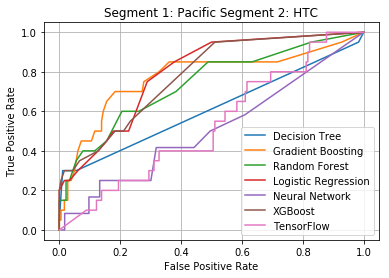

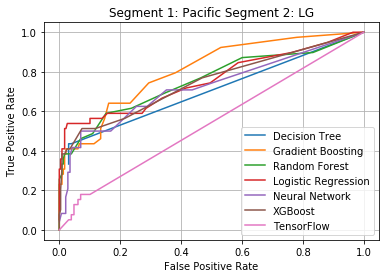

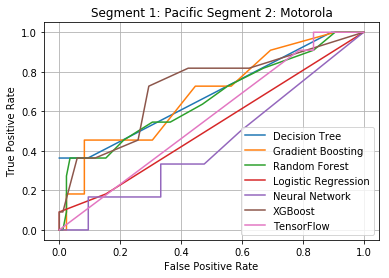

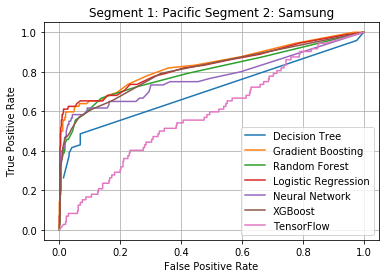

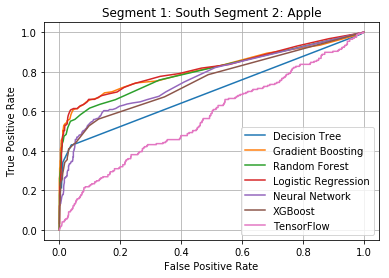

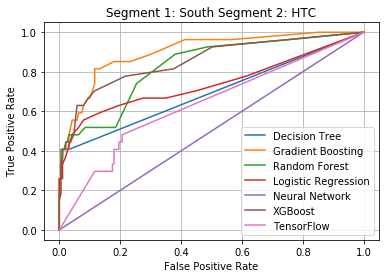

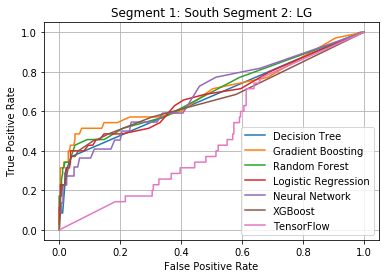

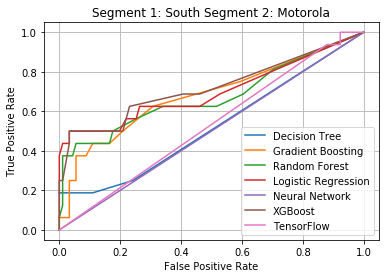

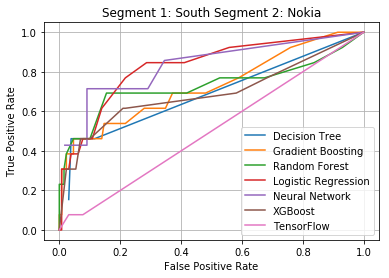

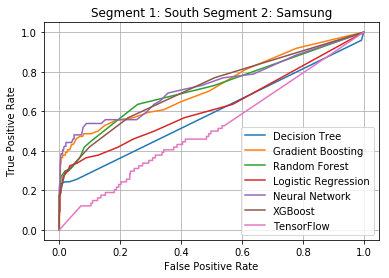

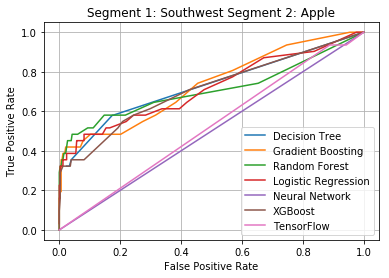

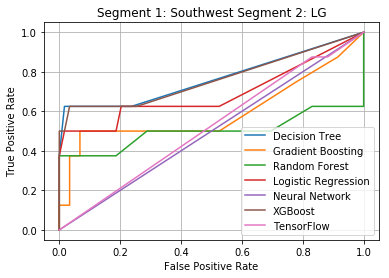

In [98]:
for m in segments_main:
    if not m['use']:
        continue
    plt.figure()
    for s in model_segments:
        if s['segment_id'] == m['segment_id']:
            
            rocinfo = s.get('ROCInfo')
            if rocinfo is not None:
                rocinfo = s.get('ROCInfo')
                
                plt.title('Segment 1: ' + str(m[segment1]) + ' Segment 2: ' + str(m[segment2]))
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.grid(True)
                plt.plot(rocinfo["FPR"], rocinfo["Sensitivity"], label=s['model'])
                plt.legend(loc="best")

#### Lift Charts

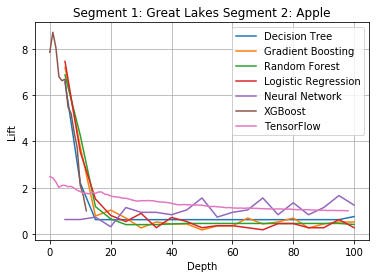

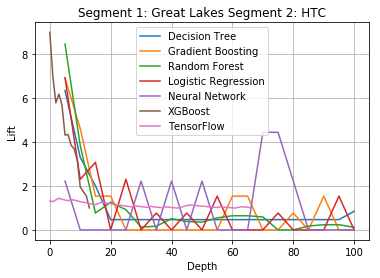

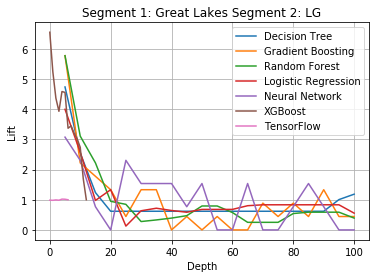

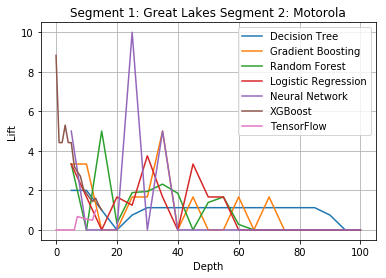

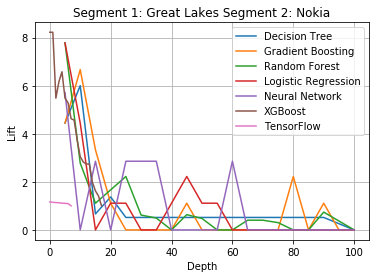

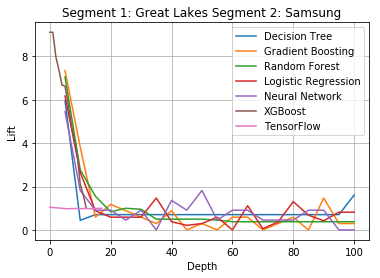

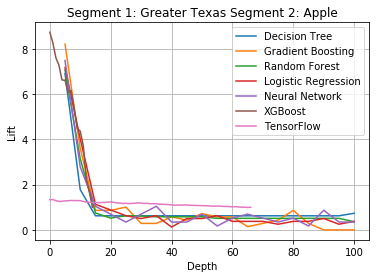

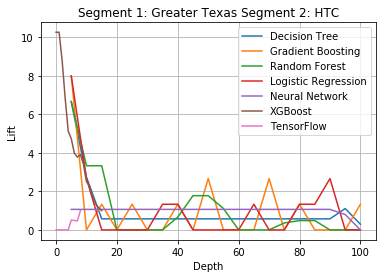

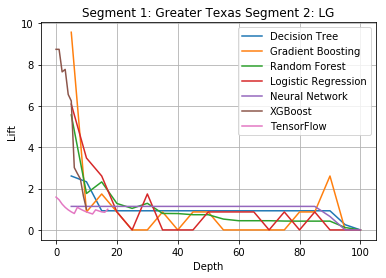

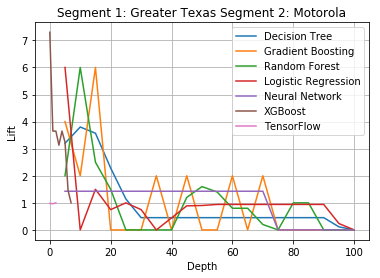

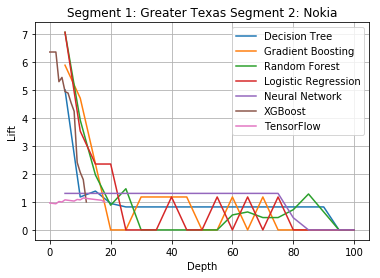

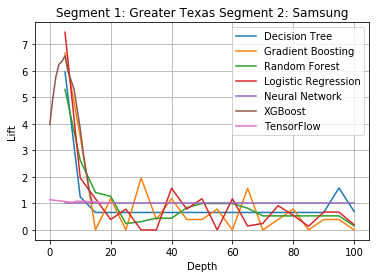

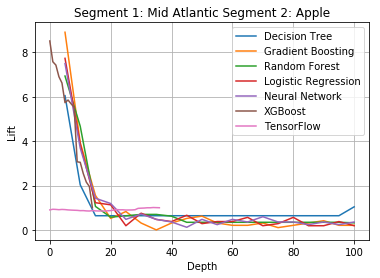

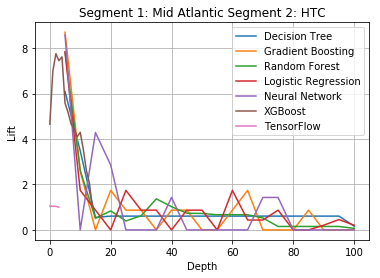

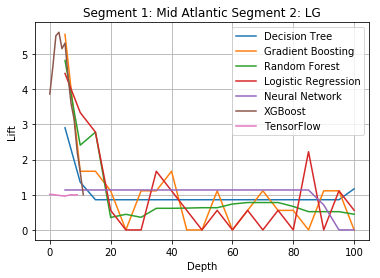

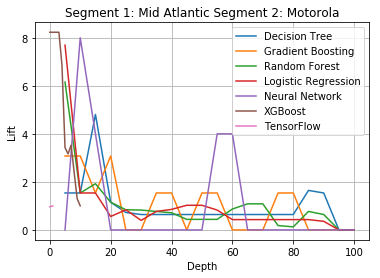

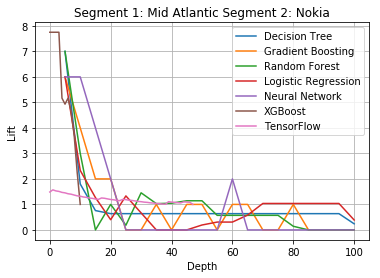

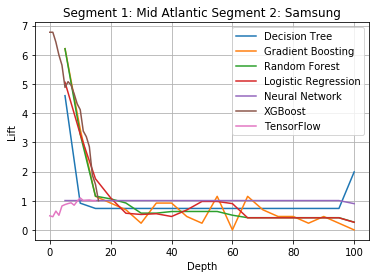

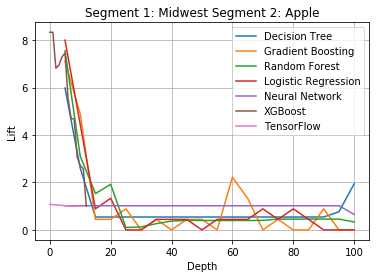

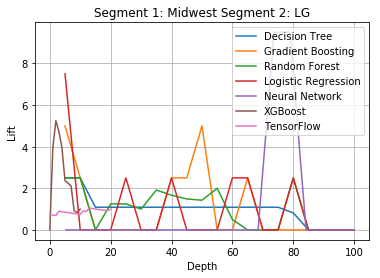

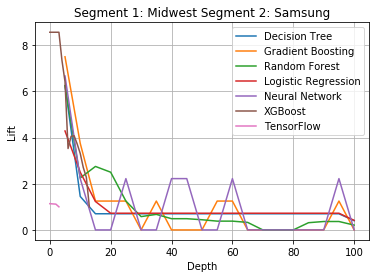

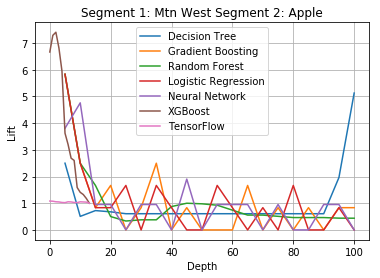

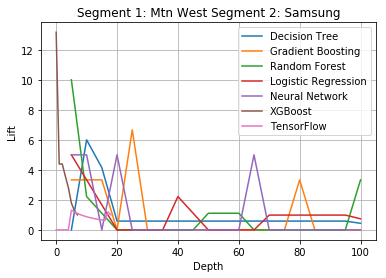

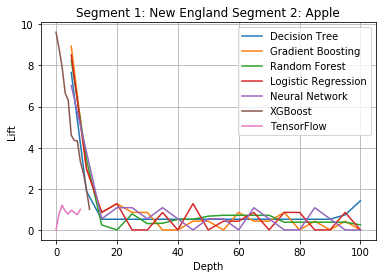

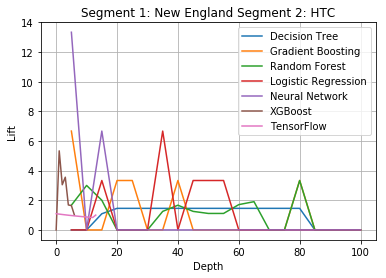

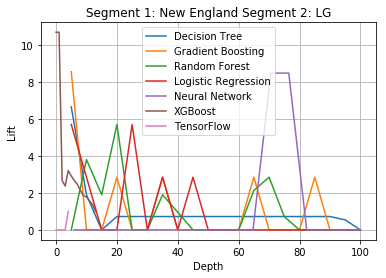

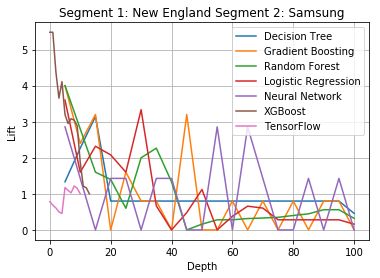

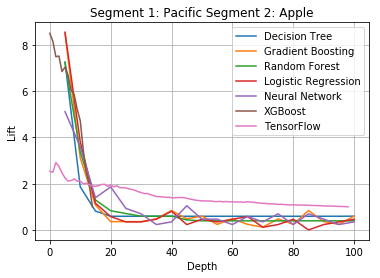

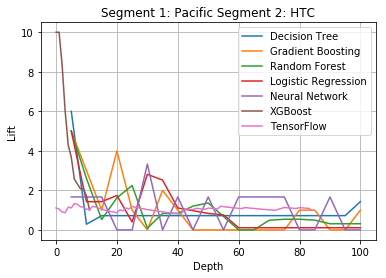

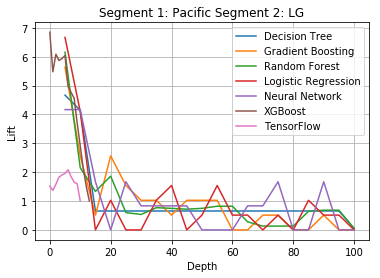

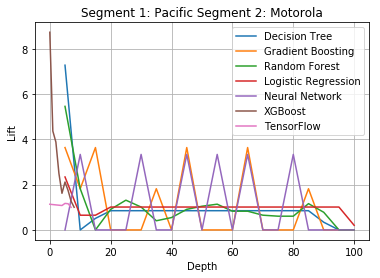

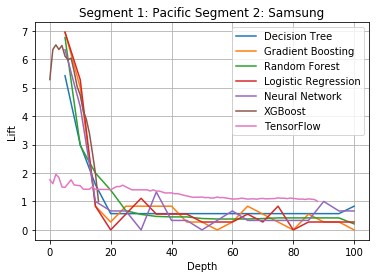

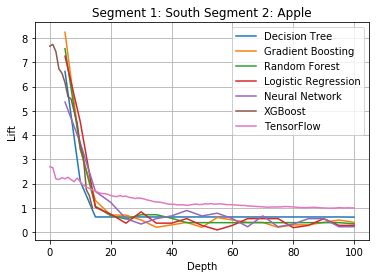

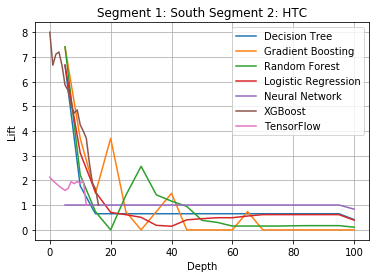

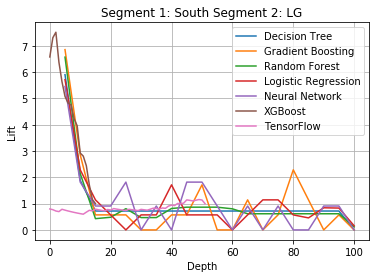

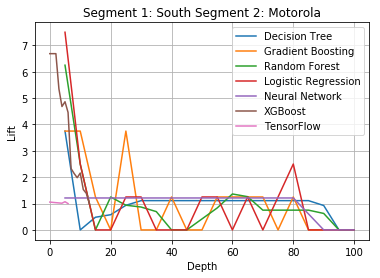

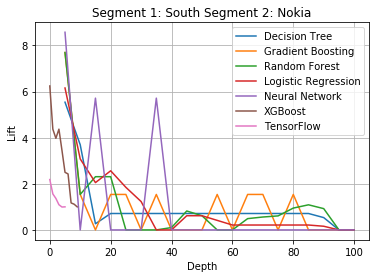

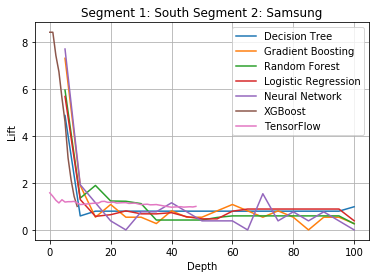

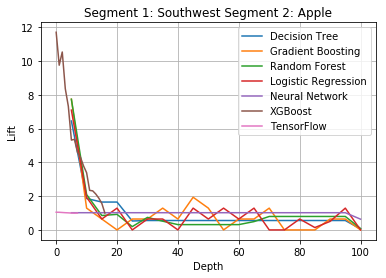

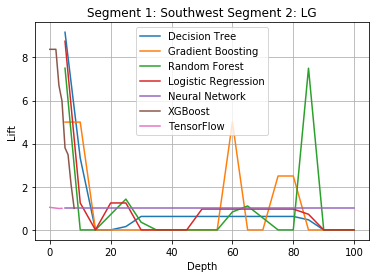

In [99]:
for m in segments_main:
    if not m['use']:
        continue
    plt.figure()
    for s in model_segments:
        if s['segment_id'] == m['segment_id']:
            rocinfo = s.get('LIFTInfo')
            if rocinfo is not None:
                plt.title('Segment 1: ' + str(m[segment1]) + ' Segment 2: ' + str(m[segment2]))
                plt.xlabel("Depth")
                plt.ylabel("Lift")
                plt.grid(True)
                if s['model'] in ['AutoML', 'XGBoost', 'TensorFlow']:
                    plt.plot(list(range(len(rocinfo))), rocinfo,label=s['model'])
                else:
                    plt.plot(rocinfo["Depth"], rocinfo["Lift"], label=s['model'])
                plt.legend(loc="best")

Summary of Results for All Segments

In [100]:
assess_res = [{'Segment ID': segment['segment_id'], segment1: segment[segment1], segment2: segment[segment2], 'Model': segment['model'], 'Misclassification': segment['misclassification'], 'Target Event Rate': segment['tgt_event_rate']} for segment in model_segments]

assess_pd = pd.DataFrame(assess_res, columns=['Segment ID', segment1, segment2, 'Model', 'Misclassification', 'Target Event Rate'])
assess_pd.set_index('Segment ID')

region   handset                Model  Misclassification  \
Segment ID                                                                  
0           Great Lakes     Apple        Decision Tree           0.089681   
0           Great Lakes     Apple    Gradient Boosting           0.077796   
0           Great Lakes     Apple        Random Forest           0.111831   
0           Great Lakes     Apple  Logistic Regression           0.077256   
0           Great Lakes     Apple       Neural Network           0.155084   
0           Great Lakes     Apple              XGBoost           0.089681   
0           Great Lakes     Apple           TensorFlow           0.240411   
1           Great Lakes       HTC        Decision Tree           0.089744   
1           Great Lakes       HTC    Gradient Boosting           0.081197   
1           Great Lakes       HTC        Random Forest           0.094017   
1           Great Lakes       HTC  Logistic Regression           0.089744   
1           Great Lakes       HTC       Neural Network           0.279279   
1           Great Lakes       HTC              XGBoost           0.089744   
1           Great Lakes       HTC           TensorFlow           0.457265   
2           Great Lakes        LG        Decision Tree           0.122034   
2           Great Lakes        LG    Gradient Boosting           0.115254   
2           Great Lakes        LG        Random Forest           0.152542   
2           Great Lakes        LG  Logistic Regression           0.142373   
2           Great Lakes        LG       Neural Network           0.279762   
2           Great Lakes        LG              XGBoost           0.145763   
2           Great Lakes        LG           TensorFlow           0.786441   
3           Great Lakes  Motorola        Decision Tree           0.207547   
3           Great Lakes  Motorola    Gradient Boosting           0.113208   
3           Great Lakes  Motorola        Random Forest           0.103774   
3           Great Lakes  Motorola  Logistic Regression           0.141509   
3           Great Lakes  Motorola       Neural Network           0.317073   
3           Great Lakes  Motorola              XGBoost           0.113208   
3           Great Lakes  Motorola           TensorFlow           0.179245   
4           Great Lakes     Nokia        Decision Tree           0.094595   
4           Great Lakes     Nokia    Gradient Boosting           0.108108   
...                 ...       ...                  ...                ...   
52                South  Motorola              XGBoost           0.121495   
52                South  Motorola           TensorFlow           0.766355   
53                South     Nokia        Decision Tree           0.112676   
53                South     Nokia    Gradient Boosting           0.077465   
53                South     Nokia        Random Forest           0.091549   
53                South     Nokia  Logistic Regression           0.070423   
53                South     Nokia       Neural Network           0.145161   
53                South     Nokia              XGBoost           0.084507   
53                South     Nokia           TensorFlow           0.112676   
54                South   Samsung        Decision Tree           0.107717   
54                South   Samsung    Gradient Boosting           0.080386   
54                South   Samsung        Random Forest           0.114148   
54                South   Samsung  Logistic Regression           0.101286   
54                South   Samsung       Neural Network           0.087678   
54                South   Samsung              XGBoost           0.098071   
54                South   Samsung           TensorFlow           0.213826   
56            Southwest     Apple        Decision Tree           0.088154   
56            Southwest     Apple    Gradient Boosting           0.066116   
56            Southwest     Apple        Random Forest           0.079890   
56           

### Find and Display the Champion Model by Misclassification for Each Segment

In [101]:
def find_champion(models):
    misclass = [model['misclassification'] for model in models if model.get('ROCInfo') is not None]
    lowest = min(misclass)
    idx = misclass.index(lowest)
    return models[idx]

champion_list = []

for segment in segments_main:
    if not segment['use']:
        continue
    all_models = [seg for seg in model_segments if segment[segment1] == seg[segment1] and segment[segment2] == seg[segment2]]
    champ = find_champion(all_models)
    champion_list.append({segment1 : champ[segment1], segment2: champ[segment2], 'Champion Model': champ['model'], 'Misclassification': champ['misclassification'], 'Target Event Rate': champ['tgt_event_rate']})

champion_pd = pd.DataFrame(champion_list, columns=[segment1, segment2, 'Champion Model', 'Misclassification', 'Target Event Rate'])
champion_pd

region   handset       Champion Model  Misclassification  \
0     Great Lakes     Apple  Logistic Regression           0.077256   
1     Great Lakes       HTC    Gradient Boosting           0.081197   
2     Great Lakes        LG    Gradient Boosting           0.115254   
3     Great Lakes  Motorola        Random Forest           0.103774   
4     Great Lakes     Nokia  Logistic Regression           0.074324   
5     Great Lakes   Samsung    Gradient Boosting           0.077419   
6   Greater Texas     Apple    Gradient Boosting           0.069558   
7   Greater Texas       HTC  Logistic Regression           0.071429   
8   Greater Texas        LG              XGBoost           0.089552   
9   Greater Texas  Motorola    Gradient Boosting           0.123288   
10  Greater Texas     Nokia  Logistic Regression           0.083333   
11  Greater Texas   Samsung  Logistic Regression           0.088889   
12   Mid Atlantic     Apple    Gradient Boosting           0.062714   
13   Mid Atlantic       HTC    Gradient Boosting           0.074766   
14   Mid Atlantic        LG    Gradient Boosting           0.107914   
15   Mid Atlantic  Motorola              XGBoost           0.102804   
16   Mid Atlantic     Nokia       Neural Network           0.093750   
17   Mid Atlantic   Samsung    Gradient Boosting           0.103565   
18        Midwest     Apple  Logistic Regression           0.066667   
19        Midwest        LG       Neural Network           0.105263   
20        Midwest   Samsung        Decision Tree           0.094891   
21       Mtn West     Apple    Gradient Boosting           0.090000   
22       Mtn West   Samsung              XGBoost           0.063291   
23    New England     Apple    Gradient Boosting           0.055310   
24    New England       HTC       Neural Network           0.090909   
25    New England        LG    Gradient Boosting           0.066667   
26    New England   Samsung  Logistic Regression           0.167883   
27        Pacific     Apple  Logistic Regression           0.060390   
28        Pacific       HTC        Decision Tree           0.080000   
29        Pacific        LG  Logistic Regression           0.093633   
30        Pacific  Motorola  Logistic Regression           0.104167   
31        Pacific   Samsung  Logistic Regression           0.071006   
32          South     Apple    Gradient Boosting           0.067270   
33          South       HTC    Gradient Boosting           0.087963   
34          South        LG    Gradient Boosting           0.087948   
35          South  Motorola  Logistic Regression           0.102804   
36          South     Nokia  Logistic Regression           0.070423   
37          South   Samsung    Gradient Boosting           0.080386   
38      Southwest     Apple    Gradient Boosting           0.066116   
39      Southwest        LG        Decision Tree           0.074627   

    Target Event Rate  
0            0.117809  
1            0.123077  
2            0.141260  
3            0.124294  
4            0.135354  
5            0.107402  
6            0.133071  
7            0.132039  
8            0.114754  
9            0.127049  
10           0.128134  
11           0.129630  
12           0.111016  
13           0.120617  
14           0.127155  
15           0.103933  
16           0.138996  
17           0.132824  
18           0.118495  
19           0.138095  
20           0.103070  
21           0.125749  
22           0.121212  
23           0.125498  
24           0.125581  
25           0.128000  
26           0.142232  
27           0.118254  
28           0.114286  
29           0.127109  
30           0.118750  
31           0.132466  
32           0.122075  
33           0.124827  
34           0.125977  
35           0.107042  
36           0.122105  
37           0.115292  
38           0.116433  
39           0.120536

### Find and Display Top Challenger Model by Misclassification for Each Segment

In [102]:
def find_challenger(models):
    misclass = [model['misclassification'] for model in models if model.get('ROCInfo') is not None]
    lowest = min(misclass)
    misclass.remove(lowest)
    second_lowest = min(misclass)
    idx = misclass.index(second_lowest)
    return models[idx]

challenger_list = []

for segment in segments_main:
    if not segment['use']:
        continue
    all_models = [seg for seg in model_segments if segment[segment1] == seg[segment1] and segment[segment2] == seg[segment2]]
    challenge = find_challenger(all_models)
    challenger_list.append({segment1 : challenge[segment1], segment2: challenge[segment2], 'Challenger Model': challenge['model'], 'Misclassification': challenge['misclassification'], 'Target Event Rate': challenge['tgt_event_rate']})

challenger_pd = pd.DataFrame(challenger_list, columns=[segment1, segment2, 'Challenger Model', 'Misclassification', 'Target Event Rate'])
challenger_pd

region   handset     Challenger Model  Misclassification  \
0     Great Lakes     Apple    Gradient Boosting           0.077796   
1     Great Lakes       HTC        Decision Tree           0.089744   
2     Great Lakes        LG        Decision Tree           0.122034   
3     Great Lakes  Motorola    Gradient Boosting           0.113208   
4     Great Lakes     Nokia        Random Forest           0.087838   
5     Great Lakes   Samsung        Decision Tree           0.085484   
6   Greater Texas     Apple        Random Forest           0.104746   
7   Greater Texas       HTC       Neural Network           0.120000   
8   Greater Texas        LG  Logistic Regression           0.094527   
9   Greater Texas  Motorola        Random Forest           0.136986   
10  Greater Texas     Nokia  Logistic Regression           0.083333   
11  Greater Texas   Samsung    Gradient Boosting           0.098765   
12   Mid Atlantic     Apple        Random Forest           0.103193   
13   Mid Atlantic       HTC        Random Forest           0.102804   
14   Mid Atlantic        LG        Decision Tree           0.122302   
15   Mid Atlantic  Motorola  Logistic Regression           0.112150   
16   Mid Atlantic     Nokia        Decision Tree           0.103226   
17   Mid Atlantic   Samsung        Random Forest           0.142615   
18        Midwest     Apple    Gradient Boosting           0.082667   
19        Midwest        LG    Gradient Boosting           0.126984   
20        Midwest   Samsung        Random Forest           0.109489   
21       Mtn West     Apple       Neural Network           0.137725   
22       Mtn West   Samsung    Gradient Boosting           0.075949   
23    New England     Apple        Decision Tree           0.075221   
24    New England       HTC    Gradient Boosting           0.093750   
25    New England        LG       Neural Network           0.294118   
26    New England   Samsung       Neural Network           0.385965   
27        Pacific     Apple    Gradient Boosting           0.063636   
28        Pacific       HTC       Neural Network           0.144000   
29        Pacific        LG        Decision Tree           0.108614   
30        Pacific  Motorola        Random Forest           0.114583   
31        Pacific   Samsung    Gradient Boosting           0.080868   
32          South     Apple        Random Forest           0.104579   
33          South       HTC       Neural Network           0.159664   
34          South        LG       Neural Network           0.117647   
35          South  Motorola  Logistic Regression           0.102804   
36          South     Nokia    Gradient Boosting           0.077465   
37          South   Samsung  Logistic Regression           0.101286   
38      Southwest     Apple        Random Forest           0.079890   
39      Southwest        LG        Random Forest           0.119403   

    Target Event Rate  
0            0.117809  
1            0.123077  
2            0.141260  
3            0.124294  
4            0.135354  
5            0.107402  
6            0.133071  
7            0.132039  
8            0.114754  
9            0.127049  
10           0.128134  
11           0.129630  
12           0.111016  
13           0.120617  
14           0.127155  
15           0.103933  
16           0.138996  
17           0.132824  
18           0.118495  
19           0.138095  
20           0.103070  
21           0.125749  
22           0.121212  
23           0.125498  
24           0.125581  
25           0.128000  
26           0.142232  
27           0.118254  
28           0.114286  
29           0.127109  
30           0.118750  
31           0.132466  
32           0.122075  
33           0.124827  
34           0.125977  
35           0.107042  
36           0.122105  
37           0.115292  
38           0.116433  
39           0.120536

#### Define Model Repository Variables

In [103]:
project_name=params_box.get(tab)['setup']['proj_name']
mm_segments = [str(segment[segment1]) + '_' + str(segment[segment2]) for segment in segments_main if segment['use']]
mm_models = params_box.get_models(tab)

#### Register Models and Save Model ID's

In [148]:
from sasctl.services import model_repository as mr
from sasctl import Session

with Session(viyaurl, username, password, verify_ssl=False):
    for i,segment in enumerate(mm_segments):
        
        project = {'id': '', 'models': [], 'segmentName': ''}
        segmentName = project_name + "_" + segment
        mr.create_project(project=segmentName, repository = 'Public',targetLevel = 'BINARY', function='classification',force=True)

        print("\nProject Name: ", segmentName)
        
        for j in range(i*len(mm_models), (i+1)*len(mm_models)):
            if model_segments[j].get('ROCInfo') is not None:
                if champion_pd['Champion Model'][champion_pd['region']==segment.split('_')[0]][champion_pd['handset']==segment.split('_')[1]].values[0].replace(' ','') ==  model_segments[j]["model"].replace(' ',''):
                    mr.create_model(model= model_segments[j]["model"] + '_' + segment,
                                project=segmentName, 
                                modeler= 'Data Scientist', 
                                function='classification', 
                                algorithm= model_segments[j]["model"],
                                is_champion=True)
                elif challenger_pd['Challenger Model'][challenger_pd['region']==segment.split('_')[0]][challenger_pd['handset']==segment.split('_')[1]].values[0].replace(' ','') ==  model_segments[j]["model"].replace(' ',''):
                    mr.create_model(model= model_segments[j]["model"] + '_' + segment,
                                project=segmentName, 
                                modeler= 'Data Scientist', 
                                function='classification', 
                                algorithm= model_segments[j]["model"],
                                is_challenger=True)
                else:
                    mr.create_model(model= model_segments[j]["model"] + '_' + segment,
                                project=segmentName, 
                                modeler= 'Data Scientist', 
                                function='classification', 
                                algorithm=model_segments[j]["model"])
                try:
                    # Upload performance files    
                    MODEL_DIR = 'automate/{}_{}-{}'.format(model_segments[j]['model'], model_segments[j]['region'], model_segments[j]['handset'])
                    file = open(MODEL_DIR + '/' + 'dmcas_roc.json', 'rb')
                    mr.add_model_content(model=model_segments[j]['model'] + '_' + segment, file=file, 
                                         name='dmcas_roc.json', role='')
                    file.close()

                    file = open(MODEL_DIR + '/' + 'dmcas_fitstat.json', 'rb')
                    mr.add_model_content(model=model_segments[j]['model'] + '_' + segment, file=file, 
                                         name='dmcas_fitstat.json', role='')
                    file.close()

                    file = open(MODEL_DIR + '/' + 'dmcas_lift.json', 'rb')
                    mr.add_model_content(model=model_segments[j]['model'] + '_' + segment, file=file, 
                                         name='dmcas_lift.json', role='')
                    file.close()
                except:
                    pass
                print("\nRegistered Model Name: ", model_segments[j]["model"] + '_' + segment)
        


Project Name:  LOOKING_GLASS_Great Lakes_Apple

Registered Model Name:  Decision Tree_Great Lakes_Apple

Registered Model Name:  Gradient Boosting_Great Lakes_Apple

Registered Model Name:  Random Forest_Great Lakes_Apple

Registered Model Name:  Logistic Regression_Great Lakes_Apple

Registered Model Name:  Neural Network_Great Lakes_Apple

Registered Model Name:  XGBoost_Great Lakes_Apple

Registered Model Name:  TensorFlow_Great Lakes_Apple

Project Name:  LOOKING_GLASS_Great Lakes_HTC

Registered Model Name:  Decision Tree_Great Lakes_HTC

Registered Model Name:  Gradient Boosting_Great Lakes_HTC

Registered Model Name:  Random Forest_Great Lakes_HTC

Registered Model Name:  Logistic Regression_Great Lakes_HTC

Registered Model Name:  Neural Network_Great Lakes_HTC

Registered Model Name:  XGBoost_Great Lakes_HTC

Registered Model Name:  TensorFlow_Great Lakes_HTC

Project Name:  LOOKING_GLASS_Great Lakes_LG

Registered Model Name:  Decision Tree_Great Lakes_LG

Registered Model N


Project Name:  LOOKING_GLASS_Midwest_Apple

Registered Model Name:  Decision Tree_Midwest_Apple

Registered Model Name:  Gradient Boosting_Midwest_Apple

Registered Model Name:  Random Forest_Midwest_Apple

Registered Model Name:  Logistic Regression_Midwest_Apple

Registered Model Name:  Neural Network_Midwest_Apple

Registered Model Name:  XGBoost_Midwest_Apple

Registered Model Name:  TensorFlow_Midwest_Apple

Project Name:  LOOKING_GLASS_Midwest_LG

Registered Model Name:  Decision Tree_Midwest_LG

Registered Model Name:  Gradient Boosting_Midwest_LG

Registered Model Name:  Random Forest_Midwest_LG

Registered Model Name:  Logistic Regression_Midwest_LG

Registered Model Name:  Neural Network_Midwest_LG

Registered Model Name:  XGBoost_Midwest_LG

Registered Model Name:  TensorFlow_Midwest_LG

Project Name:  LOOKING_GLASS_Midwest_Samsung

Registered Model Name:  Decision Tree_Midwest_Samsung

Registered Model Name:  Gradient Boosting_Midwest_Samsung

Registered Model Name:  Rando


Registered Model Name:  Neural Network_South_Samsung

Registered Model Name:  XGBoost_South_Samsung

Registered Model Name:  TensorFlow_South_Samsung

Project Name:  LOOKING_GLASS_Southwest_Apple

Registered Model Name:  Decision Tree_Southwest_Apple

Registered Model Name:  Gradient Boosting_Southwest_Apple

Registered Model Name:  Random Forest_Southwest_Apple

Registered Model Name:  Logistic Regression_Southwest_Apple

Registered Model Name:  Neural Network_Southwest_Apple

Registered Model Name:  XGBoost_Southwest_Apple

Registered Model Name:  TensorFlow_Southwest_Apple

Project Name:  LOOKING_GLASS_Southwest_LG

Registered Model Name:  Decision Tree_Southwest_LG

Registered Model Name:  Gradient Boosting_Southwest_LG

Registered Model Name:  Random Forest_Southwest_LG

Registered Model Name:  Logistic Regression_Southwest_LG

Registered Model Name:  Neural Network_Southwest_LG

Registered Model Name:  XGBoost_Southwest_LG

Registered Model Name:  TensorFlow_Southwest_LG


### Terminate All Sessions

In [ ]:
for segment in model_segments:
    segment['session'].terminate()

#### *Check Out Your Model Repository and Models in SAS Model Manager on SAS Viya*